# "GitHub repositories BigGraph and users recommendations by embeddings" project

In [1]:
from resources.utils import *

DUMP_DATE = '2019-06'

## Download data (http://ghtorrent.org/)

Run `db_download.sh` script to download dump

extract needed tables

In [2]:
!tar -C data/ -xvzf data/mysql-{DUMP_DATE}-01.tar.gz mysql-{DUMP_DATE}-01/project_members.csv mysql-{DUMP_DATE}-01/followers.csv mysql-{DUMP_DATE}-01/watchers.csv mysql-{DUMP_DATE}-01/projects.csv mysql-{DUMP_DATE}-01/users.csv

mysql-2019-06-01/followers.csv
mysql-2019-06-01/watchers.csv
mysql-2019-06-01/projects.csv
mysql-2019-06-01/project_members.csv
mysql-2019-06-01/users.csv


## Dataset preprocessing for project

The goal of this stage is to process the GitHub dataset from http://ghtorrent.org/ project into directed graph. <br>
The source data consists from .csv files which represent tabular SQL data. Each file is one table in source database. <br>
Total size of the dataset is 100GB. The size of the tables used for graph building is ~7GB.
*Database schema:*
![image.png](http://ghtorrent.org/files/schema.png)

The following tables are used for the graph representation:
* Followers
* Watchers
* Project Members

##### Graph structure 
Following nodes are defined as points of interest for this project:
* Users
* Projects

Types of graph edges:
* Follows
* Watches
* Is member of

Possible edges:
* User => follow => User
* User => follow => Project
* User => watch => User
* User => watch => Project
* User => is member => Project

In [2]:
from pyspark import SparkContext, SparkConf, SQLContext

# constants
DATA_FOLDER = f"./data/mysql-{DUMP_DATE}-01/"
FOLLOWERS_PATH = DATA_FOLDER + "followers.csv"
WATCHERS_PATH = DATA_FOLDER + "watchers.csv"
PROJECT_MEMBERS_PATH = DATA_FOLDER + "project_members.csv"

# relations constants
IS_MEMBER_OF = "is_member_of"
FOLLOWS = "follows"
WATCHES = "watches"

In [2]:
conf = SparkConf()
sc = SparkContext(conf=conf)

### Process SQL structured data into edges

In [3]:
members_rdd = sc.textFile(PROJECT_MEMBERS_PATH).map(lambda x: x.split(",")[:-2])

def addIdentifiers(row, id_1, id_2):
    '''
    Adds identifier for each id to distinguish them
    '''
    row[0] = id_1 + row[0]
    row[1] = id_2 + row[1]
    return row

def swapColumns(row):
    temp = row[0]
    row[0] = row[1]
    row[1] = temp
    return row

def addRelation(row, relation):
    temp = row[1]
    row[1] = relation
    row.append(temp)
    return row

# Processing of members table
members_rdd = members_rdd.map(lambda x: addIdentifiers(x, "repo_id_", "user_id_")).map(swapColumns).map(lambda x: addRelation(x,IS_MEMBER_OF))
members_rdd.take(5)

[['user_id_1', 'is_member_of', 'repo_id_1'],
 ['user_id_2', 'is_member_of', 'repo_id_1'],
 ['user_id_4', 'is_member_of', 'repo_id_1'],
 ['user_id_24', 'is_member_of', 'repo_id_3'],
 ['user_id_5465', 'is_member_of', 'repo_id_3']]

In [4]:
# Processing of followers table
followers_rdd = sc.textFile(FOLLOWERS_PATH).map(lambda x: x.split(",")[:-1]) \
    .map(lambda x: addIdentifiers(x, "user_id_", "user_id_")) \
    .map(swapColumns) \
    .map(lambda x: addRelation(x, FOLLOWS))

followers_rdd.take(5)

[['user_id_2', 'follows', 'user_id_1'],
 ['user_id_4', 'follows', 'user_id_1'],
 ['user_id_17896', 'follows', 'user_id_1'],
 ['user_id_21523', 'follows', 'user_id_1'],
 ['user_id_29121', 'follows', 'user_id_1']]

In [5]:
# Processing of watchers table
watchers_rdd = sc.textFile(WATCHERS_PATH).map(lambda x: x.split(",")[:-1]) \
    .map(lambda x: addIdentifiers(x, "repo_id_", "user_id_")) \
    .map(swapColumns) \
    .map(lambda x: addRelation(x, WATCHES))

watchers_rdd.take(5)

[['user_id_1', 'watches', 'repo_id_1'],
 ['user_id_2', 'watches', 'repo_id_1'],
 ['user_id_4', 'watches', 'repo_id_1'],
 ['user_id_6', 'watches', 'repo_id_1'],
 ['user_id_7', 'watches', 'repo_id_1']]

### Split into train, validation and test datasets

In [ ]:
# merge into one entity
rdd = members_rdd.union(followers_rdd).union(watchers_rdd)

sqlContext = SQLContext(sc)
df = sqlContext.createDataFrame(rdd, ['from_entity_id', 'relation', 'to_entity_id'])
df.coalesce(1).write.option("delimiter", "\t").format('com.databricks.spark.csv').options(header='true').save(DATA_FOLDER + 'graph_edges')
shuffledDF = df.randomSplit([0.1, 0.1, 0.8])
val_set = shuffledDF[0]
test_set = shuffledDF[1]
train_set = shuffledDF[2]

# save into files
val_set.coalesce(1).write.option("delimiter", "\t").format('com.databricks.spark.csv').options(header='true').save(DATA_FOLDER + 'graph_edges/validation')
test_set.coalesce(1).write.option("delimiter", "\t").format('com.databricks.spark.csv').options(header='true').save(DATA_FOLDER + 'graph_edges/test')
train_set.coalesce(1).write.option("delimiter", "\t").format('com.databricks.spark.csv').options(header='true').save(DATA_FOLDER + 'graph_edges/train')

## Store metadata

Metainfo we store in MongoDB

In [ ]:
def convert_dt(sdt):
    try:
        return pd.datetime.strptime(sdt, '%Y-%m-%d %H:%M:%S')
    except Exception as e:
        print(e)

### users

In [5]:
users_df = pd.read_csv(f'{DATA_FOLDER}users.csv',
                       header=None,
                       names=['id', 'login', 'company', 'created_at', 'type', 'fake', 'deleted', 'long', 'lat',
                              'country_code', 'state', 'city', 'location'],
#                        parse_dates=[3],
#                        quoting=1,
#                        quotechar='"',
#                        encoding='utf-8',
                       low_memory=False,
                       error_bad_lines=False).replace({'\\N': None}).set_index('id')
print(users_df.shape)
users_df['created_at'] = users_df['created_at'].map(convert_dt)
users_df = users_df[~users_df['created_at'].isna()]
users_df['fake'] = users_df['fake'].replace({1: True, 0: False, '1': True, '0': False}).astype(bool)
users_df['deleted'] = users_df['deleted'].replace({1: True, 0: False, '1': True, '0': False}).astype(bool)
users_df['long'] = users_df['long'].astype(float)
users_df['lat'] = users_df['lat'].astype(float)
users_df.shape

(30600249, 12)

In [3]:
mc['github']['users'].create_index('login')

'login_1'

In [6]:
to_insert = []

for uid, row in tn(users_df.iterrows(), total=users_df.shape[0]):
    to_insert.append({'_id': uid, **row.to_dict()})
    if len(to_insert) >= 10_000:
        mc['github']['users'].insert_many(to_insert)
        to_insert = []
if len(to_insert):
    mc['github']['users'].insert_many(to_insert)
mc['github']['users'].estimated_document_count()

30600249

Users example
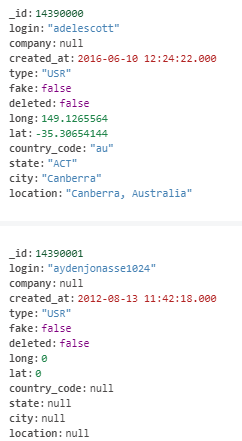

### projects (repos)

In [ ]:
for field in ['name', 'owner_id', 'url']:
    mc['github']['projects'].create_index(field)

In [7]:
try:
    stop = False
    skip_count = 0
    for i in range(1000):
        print(i)
        repos_df = pd.read_csv(f'{DATA_FOLDER}projects.csv',
                               skiprows=10_000_000*i,
                               nrows=10_000_000,
                               header=None,
                               na_values=['\\N'],
                               names=["id", "url", "owner_id", "name", "description", "language",
                                      "created_at", "forked_from", "deleted", "updated_at", "?"],
                               error_bad_lines=False,
                               low_memory=False,
                              ).set_index('id')
        c = repos_df.shape[0]
        if c < 10_000_000:
            stop = True
        repos_df['created_at'] = repos_df['created_at'].map(convert_dt)
        repos_df = repos_df[~repos_df['created_at'].isna()]
        repos_df['updated_at'] = repos_df['updated_at'].map(convert_dt)
        repos_df = repos_df[~repos_df['updated_at'].isna()]
        skip_count += (c - repos_df.shape[0])
        repos_df.index = repos_df.index.astype(int)
        repos_df['url'] = repos_df['url'].astype(str).map(lambda x: x[29:])
        repos_df['deleted'] = repos_df['deleted'].replace({1: True, 0: False, 1: True, 0: False}).astype(bool)
        repos_df['owner_id'] = repos_df['owner_id'].astype(int)
        repos_df['forked_from'] = repos_df['forked_from'].astype(float)
        repos_df['?'] = repos_df['?'].astype(float)

        to_insert = []

        for rid, row in tn(repos_df.iterrows(), total=repos_df.shape[0]):
            to_insert.append({'_id': rid, **row.to_dict()})
            if len(to_insert) >= 10_000:
                mc['github']['projects'].insert_many(to_insert)
                to_insert = []
        if len(to_insert):
            mc['github']['project'].insert_many(to_insert)
        if stop:
            break
    m = f"[projects]: stored {mc['github']['projects'].estimated_document_count()} projects, {skip_count} skiped"
    tgn(m)
except Exception as e:
    m = f'[projects]: error - {e}'
    tgn(m)
m

'[projects]: stored 116010000 projects, 135185 skiped'

Repos example
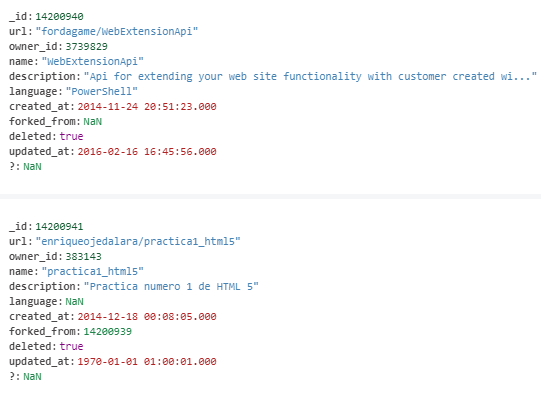

## Training (https://github.com/facebookresearch/PyTorch-BigGraph)

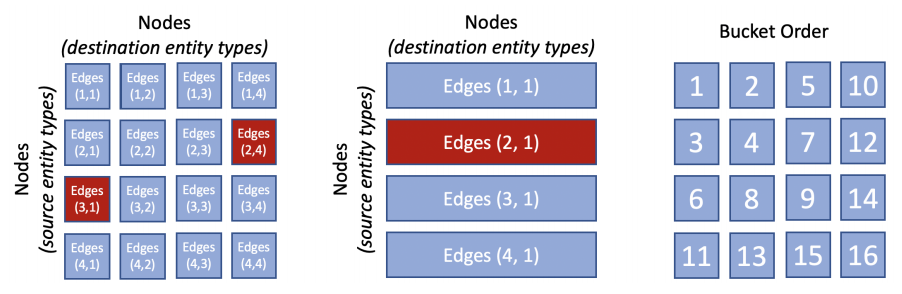
Lerer, Adam, et al. "PyTorch-BigGraph: A Large-scale Graph Embedding System." arXiv preprint arXiv:1903.12287 (2019).
https://arxiv.org/pdf/1903.12287.pdf

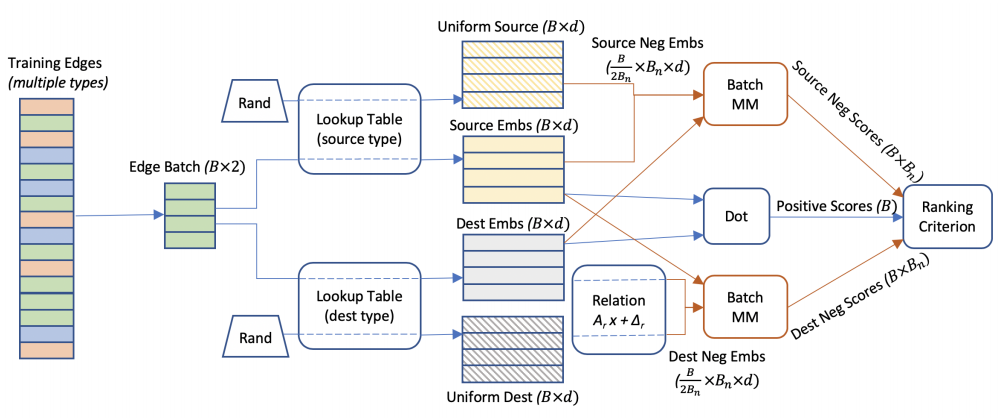
Lerer, Adam, et al. "PyTorch-BigGraph: A Large-scale Graph Embedding System." arXiv preprint arXiv:1903.12287 (2019).
https://arxiv.org/pdf/1903.12287.pdf

Clear dir from possible previous training (or archive configs)

In [14]:
for TEMPLATE in ['entity_count_all_*.txt', 'graph-*_partitioned/*', 'dictionary.json', 'dynamic_rel_count.txt']:
    !rm {DATA_FOLDER}graph_edges/{TEMPLATE}

See `graph_config.py` config file for details (`torchbiggraph_train -h` for help)

In [ ]:
ENTITY_MIN_COUNT = 10

In [ ]:
!torchbiggraph_import_from_tsv --lhs-col=0 --rel-col=1 --rhs-col=2 --entity-min-count={ENTITY_MIN_COUNT} graph_config.py {DATA_FOLDER}graph_edges/graph-*.csv > logs/formating.log

In [21]:
!head -n 20 logs/formating.log

Looking up relation types in the edge files...
- Found 4 relation types
- Removing the ones with fewer than 1 occurrences...
- Left with 4 relation types
- Shuffling them...
Searching for the entities in the edge files...
Entity type all:
- Found 27406591 entities
- Removing the ones with fewer than 10 occurrences...
- Left with 3366929 entities
- Shuffling them...
Preparing entity path ./data/mysql-2019-06-01/graph_edges:
- Writing count of entity type all and partition 0
- Writing count of entity type all and partition 1
- Writing count of entity type all and partition 2
- Writing count of entity type all and partition 3
- Writing count of dynamic relations
Preparing edge path ./data/mysql-2019-06-01/graph_edges/graph-test_partitioned, out of the edges found in ./data/mysql-2019-06-01/graph_edges/graph-test.csv
- Edges will be partitioned in 4 x 4 buckets.
- Processed 100000 edges so far...


In [14]:
for TEMPLATE in ['checkpoint_version.txt', 'embeddings_all_*.h5']:
    !rm {DATA_FOLDER}graph_edges/{TEMPLATE}

In [ ]:
!torchbiggraph_train graph_config.py -p edge_paths={DATA_FOLDER}graph_edges/graph-train_partitioned > logs/train.log

In [66]:
!head logs/train.log
print('-'*100)
!tail logs/train.log

2019-07-21 03:07:40  Loading entity counts...
2019-07-21 03:07:40  Creating workers...
2019-07-21 03:07:40  Initializing global model...
2019-07-21 03:07:40  Starting epoch 1 / 10 edge path 1 / 1 edge chunk 1 / 1
2019-07-21 03:07:40  edge_path= ./data/mysql-2019-06-01/graph_edges/graph-train_partitioned
2019-07-21 03:07:40  Swapping partitioned embeddings None ( 3 , 3 )
2019-07-21 03:07:40  Loading entities
2019-07-21 03:08:50  ( 3 , 3 ): bucket 1 / 16 : Processed 7652791 edges in 68.59 s ( 0.11 M/sec ); io: 0.51 s ( 1013.96 MB/sec )
2019-07-21 03:08:50  ( 3 , 3 ): loss:  7.348 , violators_lhs:  24.8202 , violators_rhs:  19.5466 , count:  7652791
2019-07-21 03:08:50  Swapping partitioned embeddings ( 3 , 3 ) ( 2 , 2 )
----------------------------------------------------------------------------------------------------
2019-07-21 06:00:18  ( 0 , 0 ): bucket 16 / 16 : Processed 7613224 edges in 66.93 s ( 0.11 M/sec ); io: 1.05 s ( 493.80 MB/sec )
2019-07-21 06:00:18  ( 0 , 0 ): loss:  3.1

Evaluating on validation

In [40]:
!torchbiggraph_eval graph_config.py -p edge_paths={DATA_FOLDER}graph_edges/graph-val_partitioned > logs/eval.log

In [65]:
!head logs/eval.log
print('-'*100)
!tail logs/eval.log

2019-07-21 06:00:20  Starting edge path 1 / 1 (./data/mysql-2019-06-01/graph_edges/graph-val_partitioned)
2019-07-21 06:00:22  ( 0 , 0 ): Processed 950814 edges in 2 s (0.47M/sec); load time: 0.28 s
2019-07-21 06:00:22  Stats for edge path 1 / 1, bucket ( 0 , 0 ): pos_rank:  8.92275 , mrr:  0.430614 , r1:  0.280776 , r10:  0.751336 , r50:  0.977898 , auc:  0.946762 , count:  950814
2019-07-21 06:00:24  ( 0 , 1 ): Processed 956260 edges in 1.9 s (0.5M/sec); load time: 0.17 s
2019-07-21 06:00:24  Stats for edge path 1 / 1, bucket ( 0 , 1 ): pos_rank:  9.05427 , mrr:  0.427638 , r1:  0.278619 , r10:  0.746549 , r50:  0.977637 , auc:  0.945957 , count:  956260
2019-07-21 06:00:26  ( 0 , 2 ): Processed 956350 edges in 1.9 s (0.5M/sec); load time: 0.17 s
2019-07-21 06:00:26  Stats for edge path 1 / 1, bucket ( 0 , 2 ): pos_rank:  9.39335 , mrr:  0.41802 , r1:  0.269735 , r10:  0.735591 , r50:  0.976102 , auc:  0.942434 , count:  956350
2019-07-21 06:00:28  ( 0 , 3 ): Processed 961688 edges i

## Prepare tensorboard

In [ ]:
# !torchbiggraph_export_to_tsv --dict {DATA_FOLDER}/graph_edges/dictionary.json \
# --checkpoint {DATA_FOLDER}/graph_edges/ --out {DATA_FOLDER}/graph_edges/embeddings.tsv

slow ↑ method

In [24]:
import json
import h5py
import os

!mkdir -p tb
!mkdir -p tb/embeddings

def dropCategories(df, col, threshold):
    drop_list = df[col].value_counts()[threshold:].index.to_list()
    df[col].cat.remove_categories(drop_list, inplace=True)
    return df

For faster results let's see only on repos with 1K+ stars and users with 100+ followers/following

In [31]:
good_rids = pd.read_pickle('./tb/embeddings_old/repos_19k_gte1k_old.pkl').index.tolist()
len(good_rids)

18670

In [21]:
good_uids = pd.read_pickle('./tb/embeddings_old/users_following_29k_gte100.pkl').index.tolist()
good_uids += pd.read_pickle('./tb/embeddings_old/users_followers_24k_gte100.pkl').index.tolist()
good_uids = list(set(good_uids))
len(good_uids)

47666

Read metadata

In [45]:
repos_cur = mc['github']['projects'].find({"_id": {"$in": good_rids}}, ['url', 'language', 'created_at', 'updated_at'])
repos_df = pd.DataFrame(list(repos_cur)).set_index('_id')[['url', 'language', 'created_at', 'updated_at']]
repos_df.language = repos_df.language.astype("category")
repos_df = dropCategories(repos_df, "language", 42)
repos_df

,url,language,created_at,updated_at
_id,,,,
6,cocos2d/cocos2d-x,C++,2010-11-18 23:17:00,2019-02-26 20:51:59
19,samuelclay/NewsBlur,Objective-C,2009-01-05 14:00:43,2019-02-26 03:37:41
29,opencv/opencv,C++,2012-07-19 09:40:17,2016-10-11 14:11:27
34,pockethub/PocketHub,JavaScript,2011-09-08 16:52:50,2016-10-11 14:11:27
37,angular/angular.js,JavaScript,2010-01-06 00:34:37,2019-02-27 03:14:26
49,alexgorbatchev/syntaxhighlighter,NaN,2014-10-07 13:48:58,2019-01-07 05:02:27
55,yui/yui3,JavaScript,2008-12-05 19:12:24,2019-02-26 04:45:11
71,llvm-mirror/llvm,NaN,2012-01-27 23:49:56,2019-02-26 12:59:44
74,joyent/libuv,C,2011-03-29 21:10:45,2019-02-14 03:06:31


In [22]:
ufields = ['login', 'type', 'fake', 'location', 'deleted', 'country_code', 'created_at']
users_cur = mc['github']['users'].find({"_id": {"$in": good_uids}}, ufields)
users_df = pd.DataFrame(list(users_cur)).set_index('_id')[ufields]
users_df

,login,type,fake,location,deleted,country_code,created_at
_id,,,,,,,
2,jmettraux,USR,False,Hiroshima,False,jp,2008-03-22 00:37:42
4,kennethkalmer,USR,False,"Johannesburg, South Africa",False,za,2008-04-28 17:25:53
5,weppos,USR,False,"Rome, Italy",False,it,2008-04-06 08:44:35
7,hasimo,USR,False,Tokyo/Japan,False,jp,2008-09-30 00:05:24
10,mcollina,USR,False,In the clouds above Italy,False,None,2009-02-05 21:24:19
14,nanounanue,USR,False,"Chicago, IL",False,us,2010-11-24 05:43:29
27,jimweirich,USR,False,Cincinnati,False,us,2008-03-27 18:19:22
30,minggo,USR,False,xiamen,False,cn,2010-11-19 08:06:45
31,cocos2d,ORG,False,None,False,None,2010-03-31 15:58:08


In [25]:
path = f'{DATA_FOLDER}/graph_edges'
files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.find("embeddings_all") != -1])
files = files[0:2] + files[8:] + files[2:8]
files

['./data/mysql-2019-06-01//graph_edges/embeddings_all_0.v10.h5',
 './data/mysql-2019-06-01//graph_edges/embeddings_all_1.v10.h5',
 './data/mysql-2019-06-01//graph_edges/embeddings_all_2.v10.h5',
 './data/mysql-2019-06-01//graph_edges/embeddings_all_3.v10.h5']

next actions need some RAM!

In [26]:
with open(os.path.join(path, "dictionary.json"), "rt") as tf:
    dictionary = json.load(tf)
print(dictionary['relations'])
all_entities = dictionary['entities']['all']
len(all_entities)

['is_member_of', 'relation', 'watches', 'follows']


3366929

In [48]:
pd.Series(all_entities).map(lambda x: x.split('_id_')[0]).value_counts()

user    2324058
repo    1042871
dtype: int64

Read embeddings

In [27]:
embeddings=[]
for file in tn(files):
    with h5py.File(file, "r") as hf:
        embedding = hf["embeddings"][...]
    embeddings.append(embedding)
embeddings = np.concatenate(embeddings, axis=0)
embeddings.shape

(3366929, 100)

In [28]:
emb_df = pd.Series({i: e for i, e in tn(zip(all_entities, embeddings))}).to_frame(name='embeddings')
emb_df.shape

(3366929, 1)

Combine all metainfo with embeddings

In [51]:
repos_emb_df = pd.Series({int(i.split('_')[-1]): e for i, e in emb_df.loc[[f'repo_id_{i}' for i in repos_df.index]]['embeddings'].iteritems()}).to_frame(name='embeddings')
repos_df = repos_df.join(repos_emb_df)
repos_df

,url,language,created_at,updated_at,embeddings
_id,,,,,
6,cocos2d/cocos2d-x,C++,2010-11-18 23:17:00,2019-02-26 20:51:59,"[0.009091416, -0.1736474, -0.11714197, 0.01282..."
19,samuelclay/NewsBlur,Objective-C,2009-01-05 14:00:43,2019-02-26 03:37:41,"[-0.018170146, 0.30767787, 0.28464893, 0.19292..."
29,opencv/opencv,C++,2012-07-19 09:40:17,2016-10-11 14:11:27,"[0.014859759, 0.080544606, -0.04314027, 0.2398..."
34,pockethub/PocketHub,JavaScript,2011-09-08 16:52:50,2016-10-11 14:11:27,"[-0.05337186, -0.09953255, 0.12672934, 0.29512..."
37,angular/angular.js,JavaScript,2010-01-06 00:34:37,2019-02-27 03:14:26,"[0.06040108, -0.13380292, 0.046300195, 0.15879..."
49,alexgorbatchev/syntaxhighlighter,NaN,2014-10-07 13:48:58,2019-01-07 05:02:27,"[0.06104353, -0.108160056, 0.07024201, 0.42885..."
55,yui/yui3,JavaScript,2008-12-05 19:12:24,2019-02-26 04:45:11,"[0.005732526, -0.014396505, -0.12203263, 0.064..."
71,llvm-mirror/llvm,NaN,2012-01-27 23:49:56,2019-02-26 12:59:44,"[0.124533616, 0.17850816, 0.06378259, -0.18063..."
74,joyent/libuv,C,2011-03-29 21:10:45,2019-02-14 03:06:31,"[0.09736748, -0.20508218, 0.07276151, -0.09911..."


In [29]:
users_emb_df = pd.Series({int(i.split('_')[-1]): e for i, e in emb_df.loc[[f'user_id_{i}' for i in users_df.index]]['embeddings'].iteritems()}).to_frame(name='embeddings')
users_df = users_df.join(users_emb_df)
users_df

,login,type,fake,location,deleted,country_code,created_at,embeddings
_id,,,,,,,,
2,jmettraux,USR,False,Hiroshima,False,jp,2008-03-22 00:37:42,"[0.0784233, 0.04759198, -0.101498924, 0.349370..."
4,kennethkalmer,USR,False,"Johannesburg, South Africa",False,za,2008-04-28 17:25:53,"[0.07161084, -0.38419428, 0.08797119, 0.530548..."
5,weppos,USR,False,"Rome, Italy",False,it,2008-04-06 08:44:35,"[0.07223084, -0.42726013, 0.12970544, -0.03765..."
7,hasimo,USR,False,Tokyo/Japan,False,jp,2008-09-30 00:05:24,"[0.007449036, 0.24817528, -0.10294057, 0.10895..."
10,mcollina,USR,False,In the clouds above Italy,False,None,2009-02-05 21:24:19,"[-0.0878288, -0.3583091, -0.16235128, 0.055896..."
14,nanounanue,USR,False,"Chicago, IL",False,us,2010-11-24 05:43:29,"[-0.054167535, -0.008176896, -0.04189367, 0.10..."
27,jimweirich,USR,False,Cincinnati,False,us,2008-03-27 18:19:22,"[-0.04319518, -0.06968064, -0.44799307, 0.1937..."
30,minggo,USR,False,xiamen,False,cn,2010-11-19 08:06:45,"[-0.1637608, 0.5599146, -0.16807151, 0.0782601..."
31,cocos2d,ORG,False,None,False,None,2010-03-31 15:58:08,"[-0.01550168, 0.58036375, -0.25655806, 0.29717..."


Save for TensorBoard

In [52]:
repos_df.to_pickle("./tb/embeddings/repos_19k_gte1k.pkl")

In [30]:
users_df.to_pickle("./tb/embeddings/users_48k_gte100.pkl")

In [ ]:
# repos_df.index = repos_df.index.map(lambda x: f'r{x}')
# users_df.index = users_df.index.map(lambda x: f'u{x}')
# combined_df = pd.concat([repos_df, users_df])
# combined_df.to_pickle("./tb/embeddings/repos_19k_gte1k_users_48k_gte100.pkl")

↑ embeddings for repos and users are far away from each other - no sense in viewing into combined multidimentional space

In [ ]:
!rm -r ./tb/embeddings/.ipynb_checkpoints

Now, `cd tb` & `run2.sh`